# Modeling

In [26]:
# Importing Libraries
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [27]:
# Get List of Non-Text Columns
with open('nontext_col_list.pkl', 'rb') as f:
    nontext_col_list = pickle.load(f)

len(nontext_col_list)

5512

In [28]:
# Get the data
g_drive = "G:/My Drive/ADS-599_Cap_Stone/Capstone_data/"

X_test = pd.read_pickle(g_drive + "X_test" +".pkl") 
y_test = pd.read_pickle(g_drive + "y_test" +".pkl") 
# X_train = pd.read_pickle(g_drive + "X_train" +".pkl") 
# y_train = pd.read_pickle(g_drive + "y_train" +".pkl")
X_sm_train = pd.read_pickle(g_drive + "X_sm_train" +".pkl") 
y_sm_train = pd.read_pickle(g_drive + "y_sm_train" +".pkl")


In [29]:
# Helper function to get classification model results as a dataframe
def model_stats(model_name: str, grid_search, x: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    predictions = grid_search.predict(x)
    cm = confusion_matrix(y, predictions)
    TN, FP, FN, TP = cm.flatten()
    data = {}
    data["Model"] = [model_name]
    data["Accuracy"] = [(TP + TN) / (TN + FP + FN + TP)]
    data["AUC"] = roc_auc_score(y, grid_search.predict_proba(x)[:,1])
    Precision = (TP / (TP + FP)) 
    data["Precision"] = Precision
    Recall = (TP / (TP + FN)) 
    data["Recall"] = Recall
    data["F1 Score"] = [(2 * Precision * Recall) / (Precision + Recall)] 
    return [pd.DataFrame(data), cm]

# Models Without Text Features
## Naive Bayes

In [30]:
# Remove text columns from the data
X_test_no_text = X_test[nontext_col_list]
X_sm_train_no_text = X_sm_train[nontext_col_list]

In [31]:
# Naive Bayes
# Define the model and parameter grid.
model = MultinomialNB()
grid = {"alpha": [0.002,0.001,0.0005]}

# Create the grid search object
nb_nt_grid_search = GridSearchCV(estimator=model, 
                              param_grid=grid,
                              cv=3,
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                              scoring='f1', 
                              error_score='raise'
                              )
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

# Fit the model
nb_nt_result = nb_nt_grid_search.fit(X_sm_train_no_text, y_sm_train)

# Capture the results
nb_nt_train_metrics = model_stats("Naive Bayes - w/o Text", nb_nt_grid_search, 
                                  x = X_sm_train_no_text, y = y_sm_train)
nb_nt_test_metrics = model_stats("Naive Bayes - w/o Text", nb_nt_grid_search, 
                                 x = X_test_no_text, y = y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [32]:
# Show the results of the grid search.
print("Average of the best F1 Score in the various folds during cross validation =", nb_nt_result.best_score_)
print("The best parameters found during 3-fold cross validation is =", nb_nt_result.best_params_)

Average of the best F1 Score in the various folds during cross validation = 0.8394850486063433
The best parameters found during 3-fold cross validation is = {'alpha': 0.002}


In [33]:
# Classification Report
print(
    classification_report(
        y_test,
        nb_nt_grid_search.predict(X_test_no_text),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.92      0.95      3344
Fake Job Posting       0.34      0.74      0.46       176

        accuracy                           0.91      3520
       macro avg       0.66      0.83      0.71      3520
    weighted avg       0.95      0.91      0.93      3520



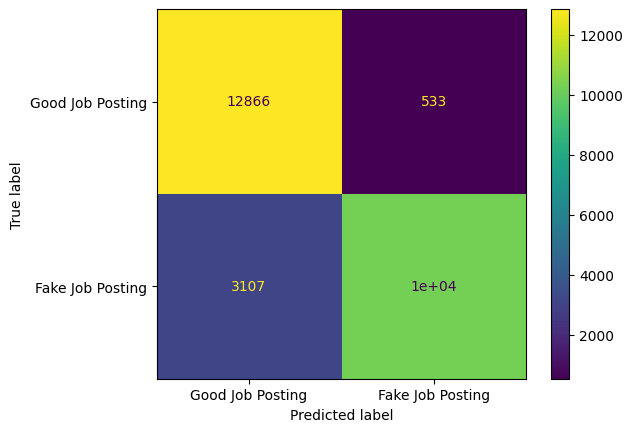

In [34]:
# Training Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    nb_nt_grid_search,
    X_sm_train_no_text,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

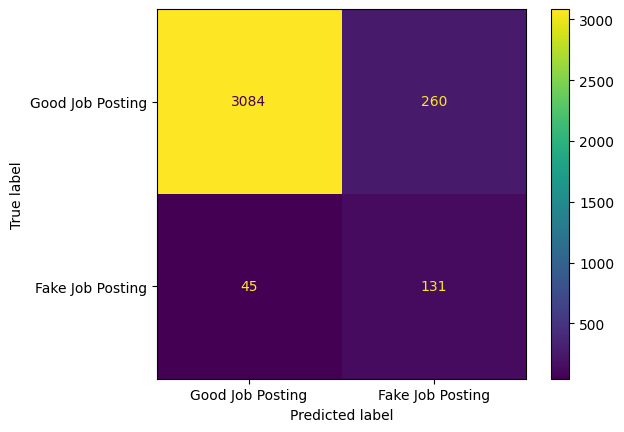

In [35]:
# Test Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    nb_nt_grid_search,
    X_test_no_text,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

## Logistic Regression

In [36]:
# Logistic Regression
# Define the model and parameter grid.
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l2']
c_values = [10000, 5000, 1000]
grid = dict(solver=solvers,penalty=penalty,C=c_values)

# define grid search
lr_nt_grid_search = GridSearchCV(estimator=model, 
                              param_grid=grid, 
                              cv=3,
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                              scoring='f1',
                              error_score='raise'
                              )
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

# Fit the model
lr_nt_result = lr_nt_grid_search.fit(X_sm_train_no_text, y_sm_train)

# Capture the results
lr_nt_train_metrics = model_stats("Logistic Regression - w/o Text", lr_nt_grid_search, 
                                  x = X_sm_train_no_text, y = y_sm_train)
lr_nt_test_metrics = model_stats("Logistic Regression - w/o Text", lr_nt_grid_search, 
                                 x = X_test_no_text, y = y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [37]:
# Show the results of the grid search.
print("Average of the best F1 Score in the various folds during cross validation =", lr_nt_result.best_score_)
print("The best parameters found during 3-fold cross validation is =", lr_nt_result.best_params_)

Average of the best F1 Score in the various folds during cross validation = 0.9375662202383185
The best parameters found during 3-fold cross validation is = {'C': 10000, 'penalty': 'l2', 'solver': 'liblinear'}


In [38]:
# Classification Report
print(
    classification_report(
        y_test,
        lr_nt_grid_search.predict(X_test_no_text),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.91      0.95      3344
Fake Job Posting       0.31      0.77      0.44       176

        accuracy                           0.90      3520
       macro avg       0.65      0.84      0.69      3520
    weighted avg       0.95      0.90      0.92      3520



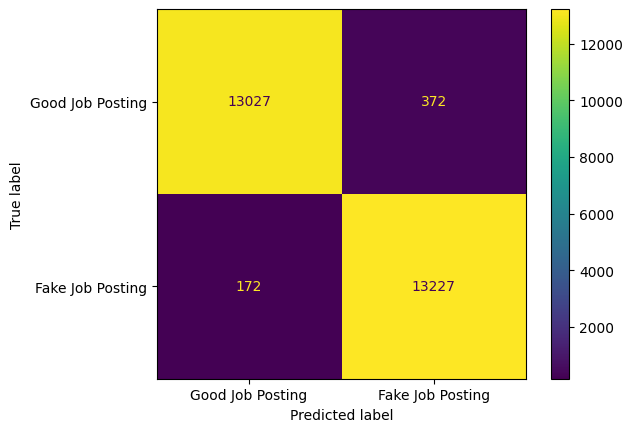

In [39]:
# Training Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    lr_nt_grid_search,
    X_sm_train_no_text,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

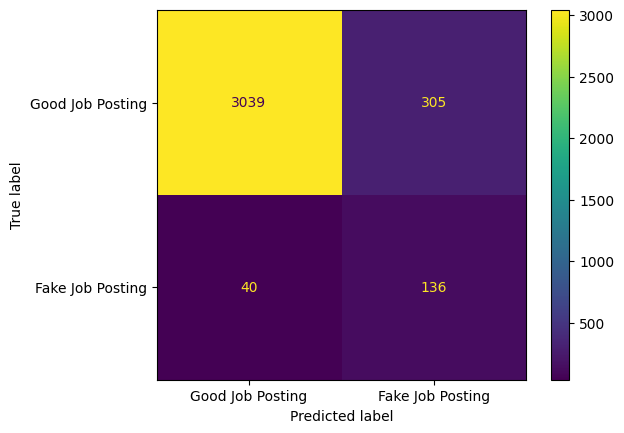

In [40]:
# Test Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    lr_nt_grid_search,
    X_test_no_text,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

# Models With Text Features
## Naive Bayes

In [41]:
# Naive Bayes
# Define the model and parameter grid.
model = MultinomialNB()
grid = {"alpha": [0.002,0.001,0.0005]}

# Create the grid search object
nb_grid_search = GridSearchCV(estimator=model, 
                              param_grid=grid,
                              cv=3,
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                              scoring='f1', 
                              error_score='raise'
                              )
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

# Fit the model
nb_result = nb_grid_search.fit(X_sm_train, y_sm_train)

# Capture the results
nb_train_metrics = model_stats("Naive Bayes", nb_grid_search, x = X_sm_train, y = y_sm_train)
nb_test_metrics = model_stats("Naive Bayes", nb_grid_search, x = X_test, y = y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [42]:
# Show the results of the grid search.
print("Average of the best F1 Score in the various folds during cross validation =", nb_result.best_score_)
print("The best parameters found during 3-fold cross validation is =", nb_result.best_params_)

Average of the best F1 Score in the various folds during cross validation = 0.9686979443822151
The best parameters found during 3-fold cross validation is = {'alpha': 0.0005}


In [43]:
# Classification Report
print(
    classification_report(
        y_test,
        nb_grid_search.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.99      0.99      3344
Fake Job Posting       0.76      0.77      0.76       176

        accuracy                           0.98      3520
       macro avg       0.87      0.88      0.88      3520
    weighted avg       0.98      0.98      0.98      3520



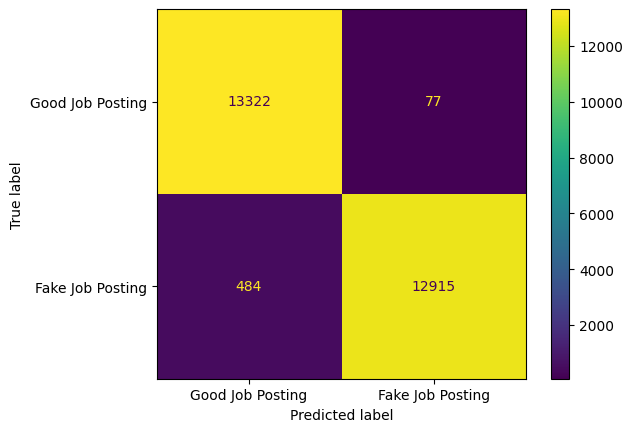

In [44]:
# Training Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    nb_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

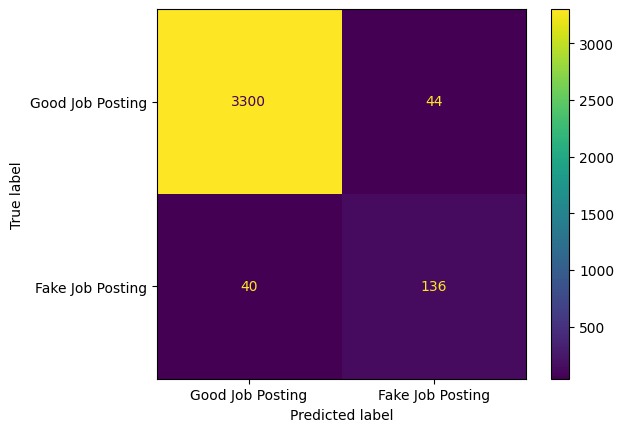

In [45]:
# Test Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    nb_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

# Logistic Regression

In [46]:
# Logistic Regression
# Define the model and parameter grid.
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l2']
c_values = [10000, 5000, 1000]
grid = dict(solver=solvers,penalty=penalty,C=c_values)

# define grid search
lr_grid_search = GridSearchCV(estimator=model, 
                              param_grid=grid, 
                              cv=3,
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                              scoring='f1',
                              error_score='raise'
                              )
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

# Fit the model
lr_result = lr_grid_search.fit(X_sm_train, y_sm_train)

# Capture the results
lr_train_metrics = model_stats("Logistic Regression", lr_grid_search, x = X_sm_train, y = y_sm_train)
lr_test_metrics = model_stats("Logistic Regression", lr_grid_search, x = X_test, y = y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [47]:
# Show the results of the grid search.
print("Average of the best F1 Score in the various folds during cross validation =", lr_result.best_score_)
print("The best parameters found during 3-fold cross validation is =", lr_result.best_params_)

Average of the best F1 Score in the various folds during cross validation = 0.9911004756955325
The best parameters found during 3-fold cross validation is = {'C': 5000, 'penalty': 'l2', 'solver': 'liblinear'}


In [48]:
# Classification Report
print(
    classification_report(
        y_test,
        lr_result.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.99      0.99      3344
Fake Job Posting       0.81      0.88      0.84       176

        accuracy                           0.98      3520
       macro avg       0.90      0.93      0.92      3520
    weighted avg       0.98      0.98      0.98      3520



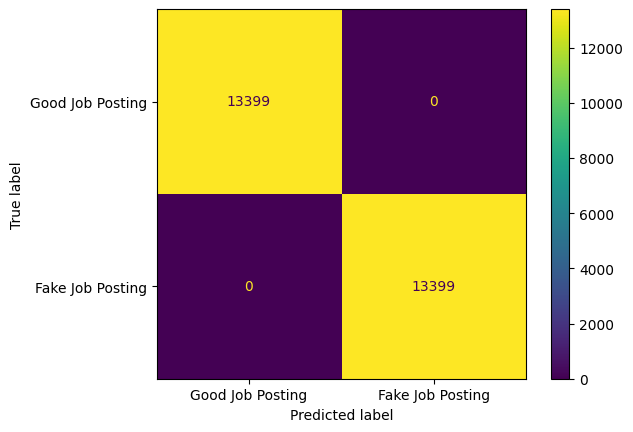

In [49]:
# Training Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    lr_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

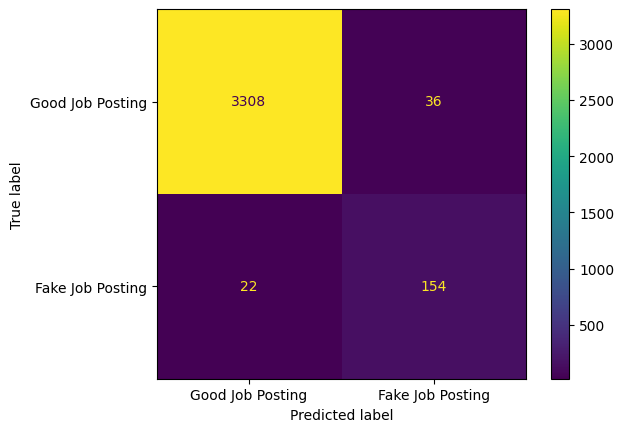

In [50]:
# Test Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    lr_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

# Gradiant Boosting Machine for Classification

In [51]:
# Gradient Boosting Machine for Classification
# Define the model and parameter grid.
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10)
grid = {'max_depth':range(12,16,2), 
        'min_samples_split':range(100,201,25)
        }

# Create the grid search object
gbm_grid_search = GridSearchCV(estimator=model, 
                               param_grid=grid,
                               cv=3,
                               return_train_score=True,
                               verbose=2,
                               n_jobs=-1,
                               scoring='f1', # 'recall' # 'precision' # 'recall' # 'roc_auc' # 'accuracy' # 
                               error_score='raise'
                               )
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

# Fit the model
gbm_result = gbm_grid_search.fit(X_sm_train, y_sm_train)

# Capture the results
gbm_train_metrics = model_stats("Gradient Boosting Machine", gbm_grid_search, x = X_sm_train, y = y_sm_train)
gbm_test_metrics = model_stats("Gradient Boosting Machine", gbm_grid_search, x = X_test, y = y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [52]:
print("Average of the best F1 Score in the various folds during cross validation =", gbm_result.best_score_)
print("The best parameters found during 3-fold cross validation is =", gbm_result.best_params_)

Average of the best F1 Score in the various folds during cross validation = 0.9923859858101339
The best parameters found during 3-fold cross validation is = {'max_depth': 14, 'min_samples_split': 100}


In [53]:
# Classification Report
print(
    classification_report(
        y_test,
        gbm_result.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.99      0.99      3344
Fake Job Posting       0.82      0.76      0.79       176

        accuracy                           0.98      3520
       macro avg       0.90      0.88      0.89      3520
    weighted avg       0.98      0.98      0.98      3520



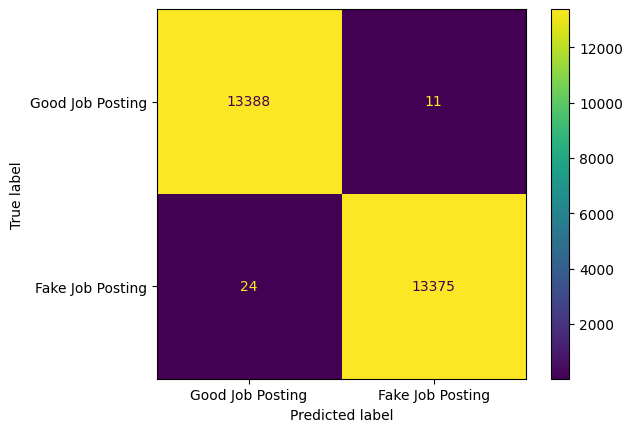

In [54]:
# Training Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    gbm_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

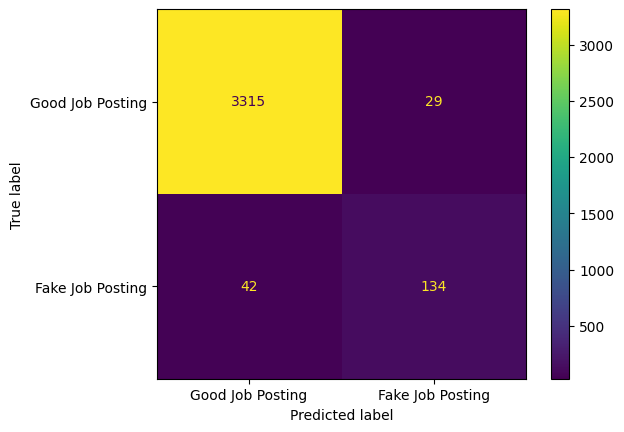

In [55]:
# Test Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    gbm_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

# Random Forest Classifier


In [56]:
# Random Forest Classifier
# Define the model and parameter grid.
model = RandomForestClassifier(n_estimators = 100)  
grid = {
        'bootstrap': [True, False],
        'max_features': ['sqrt']
        }

# Create the grid search object
rf_grid_search = GridSearchCV(estimator=model, 
                               param_grid=grid, 
                               n_jobs=-1,
                               cv=3, # 3-fold cross-validation
                               scoring='f1',
                               error_score='raise')
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

# Fit the model
rf_result = rf_grid_search.fit(X_sm_train, y_sm_train)

# Capture the results
rf_train_metrics = model_stats("Random Forest", rf_grid_search, x = X_sm_train, y = y_sm_train)
rf_test_metrics = model_stats("Random Forest", rf_grid_search, x = X_test, y = y_test)

In [57]:
print("Average of the best F1 Score in the various folds during cross validation =", rf_result.best_score_)
print("The best parameters found during 3-fold cross validation is =", rf_result.best_params_)

Average of the best F1 Score in the various folds during cross validation = 0.9983910945379773
The best parameters found during 3-fold cross validation is = {'bootstrap': False, 'max_features': 'sqrt'}


In [58]:
# Classification Report
print(
    classification_report(
        y_test,
        rf_grid_search.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.98      1.00      0.99      3344
Fake Job Posting       0.98      0.63      0.77       176

        accuracy                           0.98      3520
       macro avg       0.98      0.82      0.88      3520
    weighted avg       0.98      0.98      0.98      3520



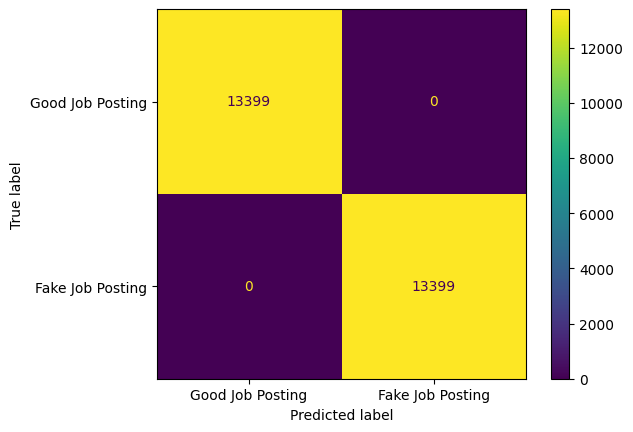

In [59]:
# Training Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    rf_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

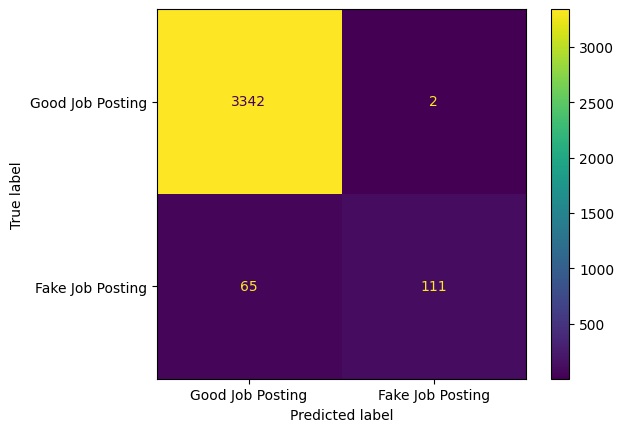

In [60]:
# Test Set Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    rf_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

# Model Results

In [61]:
# Train Metrics
training_metrics = pd.concat([nb_nt_train_metrics[0], lr_nt_train_metrics[0],
                              nb_train_metrics[0], lr_train_metrics[0], 
                              gbm_train_metrics[0], rf_test_metrics[0]], axis=0)
training_metrics

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Naive Bayes - w/o Text,0.864169,0.982637,0.950762,0.768117,0.849736
0,Logistic Regression - w/o Text,0.979700,0.997751,0.972645,0.987163,0.979850
0,Naive Bayes,0.979066,0.999048,0.994073,0.963878,0.978743
0,Logistic Regression,1.000000,1.000000,1.000000,1.000000,1.000000
0,Gradient Boosting Machine,0.998694,0.999992,0.999178,0.998209,0.998693
0,Random Forest,0.980966,0.991611,0.982301,0.630682,0.768166


In [62]:
# Test Metrics
test_metrics = pd.concat([nb_nt_test_metrics[0], lr_nt_test_metrics[0],
                          nb_test_metrics[0], lr_test_metrics[0], 
                          gbm_test_metrics[0], rf_test_metrics[0]], axis=0)
test_metrics

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Naive Bayes - w/o Text,0.913352,0.914234,0.335038,0.744318,0.462081
0,Logistic Regression - w/o Text,0.901989,0.917998,0.308390,0.772727,0.440843
0,Naive Bayes,0.976136,0.970600,0.755556,0.772727,0.764045
0,Logistic Regression,0.983523,0.985872,0.810526,0.875000,0.841530
0,Gradient Boosting Machine,0.979830,0.986823,0.822086,0.761364,0.790560
0,Random Forest,0.980966,0.991611,0.982301,0.630682,0.768166


In [63]:
# Save the data set as pickle file
g_drive = "G:/My Drive/ADS-599_Cap_Stone/Capstone_data/"

training_metrics.to_pickle(g_drive + "training_metrics.pkl") 
test_metrics.to_pickle(g_drive + "test_metrics.pkl") 